<a href="https://colab.research.google.com/github/charlesyoo/lga-python-summer23/blob/main/Final_Project_ML_LSTM_Charles_Yoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Conclusion:

I used LSTM and achieved the accuracy rate of 89%. The reason why I used it was because it was the last model we'd learned regarding time series. As I did further research, I learned it works as well on sequential data sets. And, NLP is actually the sequential parsing of parts of language. I also cleaned the tweets by trying to eliminate noise such as retweets and hashtags. I still have to play around with the data set to understand whether I can improve accuracy by converting other columns as well, such as confident level and golden. In conclusion, I have so much work ahead. Thank you!

In [5]:
import itertools
import pandas as pd
import numpy as np
import string
import nltk
import nltk.corpus
import sklearn
import csv
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk import NaiveBayesClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from keras.models import load_model

# tokenize the dataset corpus, delete uncommon words such as names.
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text, sequence
from IPython.display import display, HTML
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, accuracy_score, f1_score,recall_score, roc_auc_score,precision_recall_curve, average_precision_score, auc, roc_curve
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.metrics import classification_report

from keras.utils import plot_model
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pickle

sns.set()

In [6]:
nltk.download('stopwords') # downloads a set of common stopwords
nltk.download('punkt') # downloads Punkt tokenizer models for nlp tokenization. Splits text into sentences & words
nltk.download('averaged_perceptron_tagger') # downloads part-of-speech tagging such as noun, verb, etc
nltk.download('wordnet') # downloads lexical database for synonyms & semantic similarity
nltk.download('omw-1.4') # downloads cross language mapping (?)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [7]:
# Reading the data after uploading to Github
data = pd.read_csv('https://raw.githubusercontent.com/charlesyoo/ML-Data/main/Apple-Twitter-Sentiment-DFE%20-%20Apple-Twitter-Sentiment-DFE.csv')

# EDA

In [8]:
data.head(10) # Pulling first ten rows

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL
5,623495518,True,golden,13,NaN,3,0.5975,Mon Dec 01 20:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,5,#AAPL:5 Rocket Stocks to Buy for December Gain...
6,623495519,True,golden,13,NaN,5,0.8468,Mon Dec 01 20:32:45 +0000 2014,5.400000e+17,#AAPL OR @Apple,5,Top 3 all @Apple #tablets. Damn right! http://...
7,623495520,True,golden,9,NaN,5,0.6736,Mon Dec 01 20:34:31 +0000 2014,5.400000e+17,#AAPL OR @Apple,5\n3,CNBCTV: #Apple's margins better than expected?...
8,623495521,True,golden,15,NaN,3,0.7997,Mon Dec 01 20:36:47 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,Apple Inc. Flash Crash: What You Need to Know ...
9,623495522,False,finalized,3,12/12/14 0:52,3,0.6360,Mon Dec 01 20:45:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,#AAPL:This Presentation Shows What Makes The W...


In [9]:
data.describe() # Key measures for data

,_unit_id,_trusted_judgments,sentiment:confidence,id
count,3.886000e+03,3886.000000,3886.000000,3.886000e+03
mean,6.234975e+08,3.687082,0.829526,5.410039e+17
std,1.171906e+03,2.004595,0.175864,7.942752e+14
min,6.234955e+08,3.000000,0.332700,5.400000e+17
25%,6.234965e+08,3.000000,0.674475,5.400000e+17
50%,6.234975e+08,3.000000,0.811250,5.410000e+17
75%,6.234984e+08,3.000000,1.000000,5.420000e+17
max,6.235173e+08,27.000000,1.000000,5.420000e+17


In [10]:
data['_trusted_judgments'].value_counts() # unique values in trusted judgments

3     3063
6      362
4      309
5       29
13      17
12      15
14      14
7       11
8       10
16       9
17       9
15       9
10       6
11       6
9        6
19       5
18       3
22       2
27       1
Name: _trusted_judgments, dtype: int64

In [11]:
# How many tweets we have
print('There are', data.shape[0], 'tweeets')

# check for duplicates
print("There are", len(data[data.duplicated()]), "duplicates")

# check if we have missing values
print("There are", data.isnull().sum().sum(), "missing values")

There are 3886 tweeets
There are 0 duplicates
There are 3886 missing values


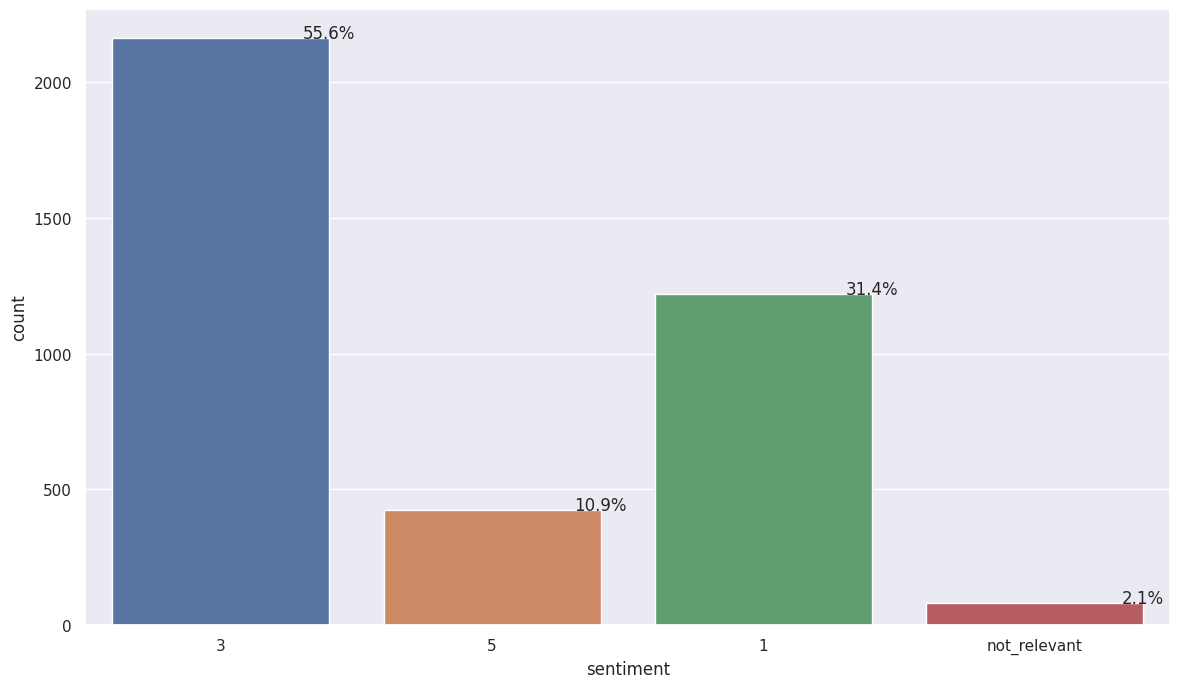

In [12]:
# visualizing
plt.figure(figsize=(14,8))
total = float(len(data)) # Creates a count plot for the bar chart by calc. total data points
ax = sns.countplot(x="sentiment", data=data) # for the sentiment column, counting unique values for bars
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [13]:
data.head() # Reviewing the data again

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [14]:
# Filtering out the first 10 rows where the sentiment:confidence is 1 & _golden is True.
data[data['sentiment:confidence'] == 1][data["_golden"]== True].head(10)

<ipython-input-14-500253917143>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['sentiment:confidence'] == 1][data["_golden"]== True].head(10)


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
2,623495515,True,golden,10,NaN,3,1.0,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
10,623495523,True,golden,12,NaN,1,1.0,Mon Dec 01 20:46:01 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
14,623495527,True,golden,17,NaN,1,1.0,Mon Dec 01 21:09:50 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,@apple Contact sync between Yosemite and iOS8 ...
23,623495536,True,golden,13,NaN,1,1.0,Mon Dec 01 23:55:55 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,"@Apple, For the love of GAWD, CENTER the '1'on..."
37,623495550,True,golden,9,NaN,3,1.0,Tue Dec 02 00:23:47 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,http://t.co/hpC7p1rHvA\nneed help on using you...
44,623495557,True,golden,10,NaN,1,1.0,Tue Dec 02 00:29:58 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,"Ok, @apple. You win. I won't use your browser ..."
47,623495560,True,golden,16,NaN,1,1.0,Tue Dec 02 00:34:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,@apple U need to get ur fucking shit together ...
57,623495570,True,golden,14,NaN,1,1.0,Tue Dec 02 00:53:58 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,hey @apple fuck you
63,623495576,True,golden,18,NaN,1,1.0,Tue Dec 02 01:05:37 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,"As a die hard @Apple customer, I must say I am..."
163,623495676,True,golden,17,NaN,1,1.0,Tue Dec 02 06:52:06 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,fucking faggots @apple


In [15]:
# Converting 'not_relevent' to 0
data['sentiment'] = data['sentiment'].replace('not_relevant', '0')

In [16]:
# Converting sentiment from string to numeric values
data['sentiment'] = pd.to_numeric(data['sentiment'])

In [17]:
# Deleting the rows with 0
data.drop(data[data['sentiment'] == 0].index, inplace=True)


In [18]:
data['sentiment'].value_counts() # counting the values

3    2162
1    1219
5     423
Name: sentiment, dtype: int64

In [19]:
# Creating an array called categories from a lambda function for binary designation - if x is greater than 3,
# label it with 1, if not place 0.
categories = pd.DataFrame(data['sentiment'].apply(lambda x: 1 if (x > 3) else 0) ).to_numpy()
categories

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [20]:
# create new  column called sentiment leel and store the positive for the sentiment over 3 and negaive for the rest
data['sentiment_level'] = data['sentiment'].apply(lambda x: "Positive" if (x > 3) else "Negative")
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text,sentiment_level
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...,Negative
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,Negative
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...,Negative
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...,Negative
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL,Negative


In [21]:
data.head(10)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text,sentiment_level
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...,Negative
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,Negative
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...,Negative
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...,Negative
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL,Negative
5,623495518,True,golden,13,NaN,3,0.5975,Mon Dec 01 20:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,5,#AAPL:5 Rocket Stocks to Buy for December Gain...,Negative
6,623495519,True,golden,13,NaN,5,0.8468,Mon Dec 01 20:32:45 +0000 2014,5.400000e+17,#AAPL OR @Apple,5,Top 3 all @Apple #tablets. Damn right! http://...,Positive
7,623495520,True,golden,9,NaN,5,0.6736,Mon Dec 01 20:34:31 +0000 2014,5.400000e+17,#AAPL OR @Apple,5\n3,CNBCTV: #Apple's margins better than expected?...,Positive
8,623495521,True,golden,15,NaN,3,0.7997,Mon Dec 01 20:36:47 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,Apple Inc. Flash Crash: What You Need to Know ...,Negative
9,623495522,False,finalized,3,12/12/14 0:52,3,0.6360,Mon Dec 01 20:45:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,#AAPL:This Presentation Shows What Makes The W...,Negative


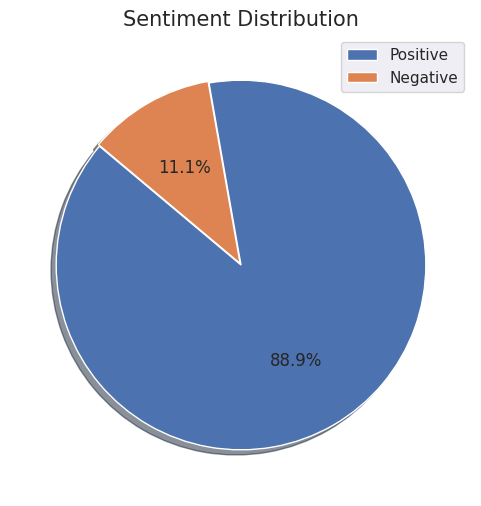

In [22]:
#Creating a pie chart
plt.figure(figsize=(6, 6))# with the size of 6 by 6 inches
explode = [0, 0.01] #Slightly "exploding" the second slide
plt.pie(data['sentiment_level'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=['Positive', 'Negative'])
plt.title('Sentiment Distribution', fontsize=15)
plt.axis('off');

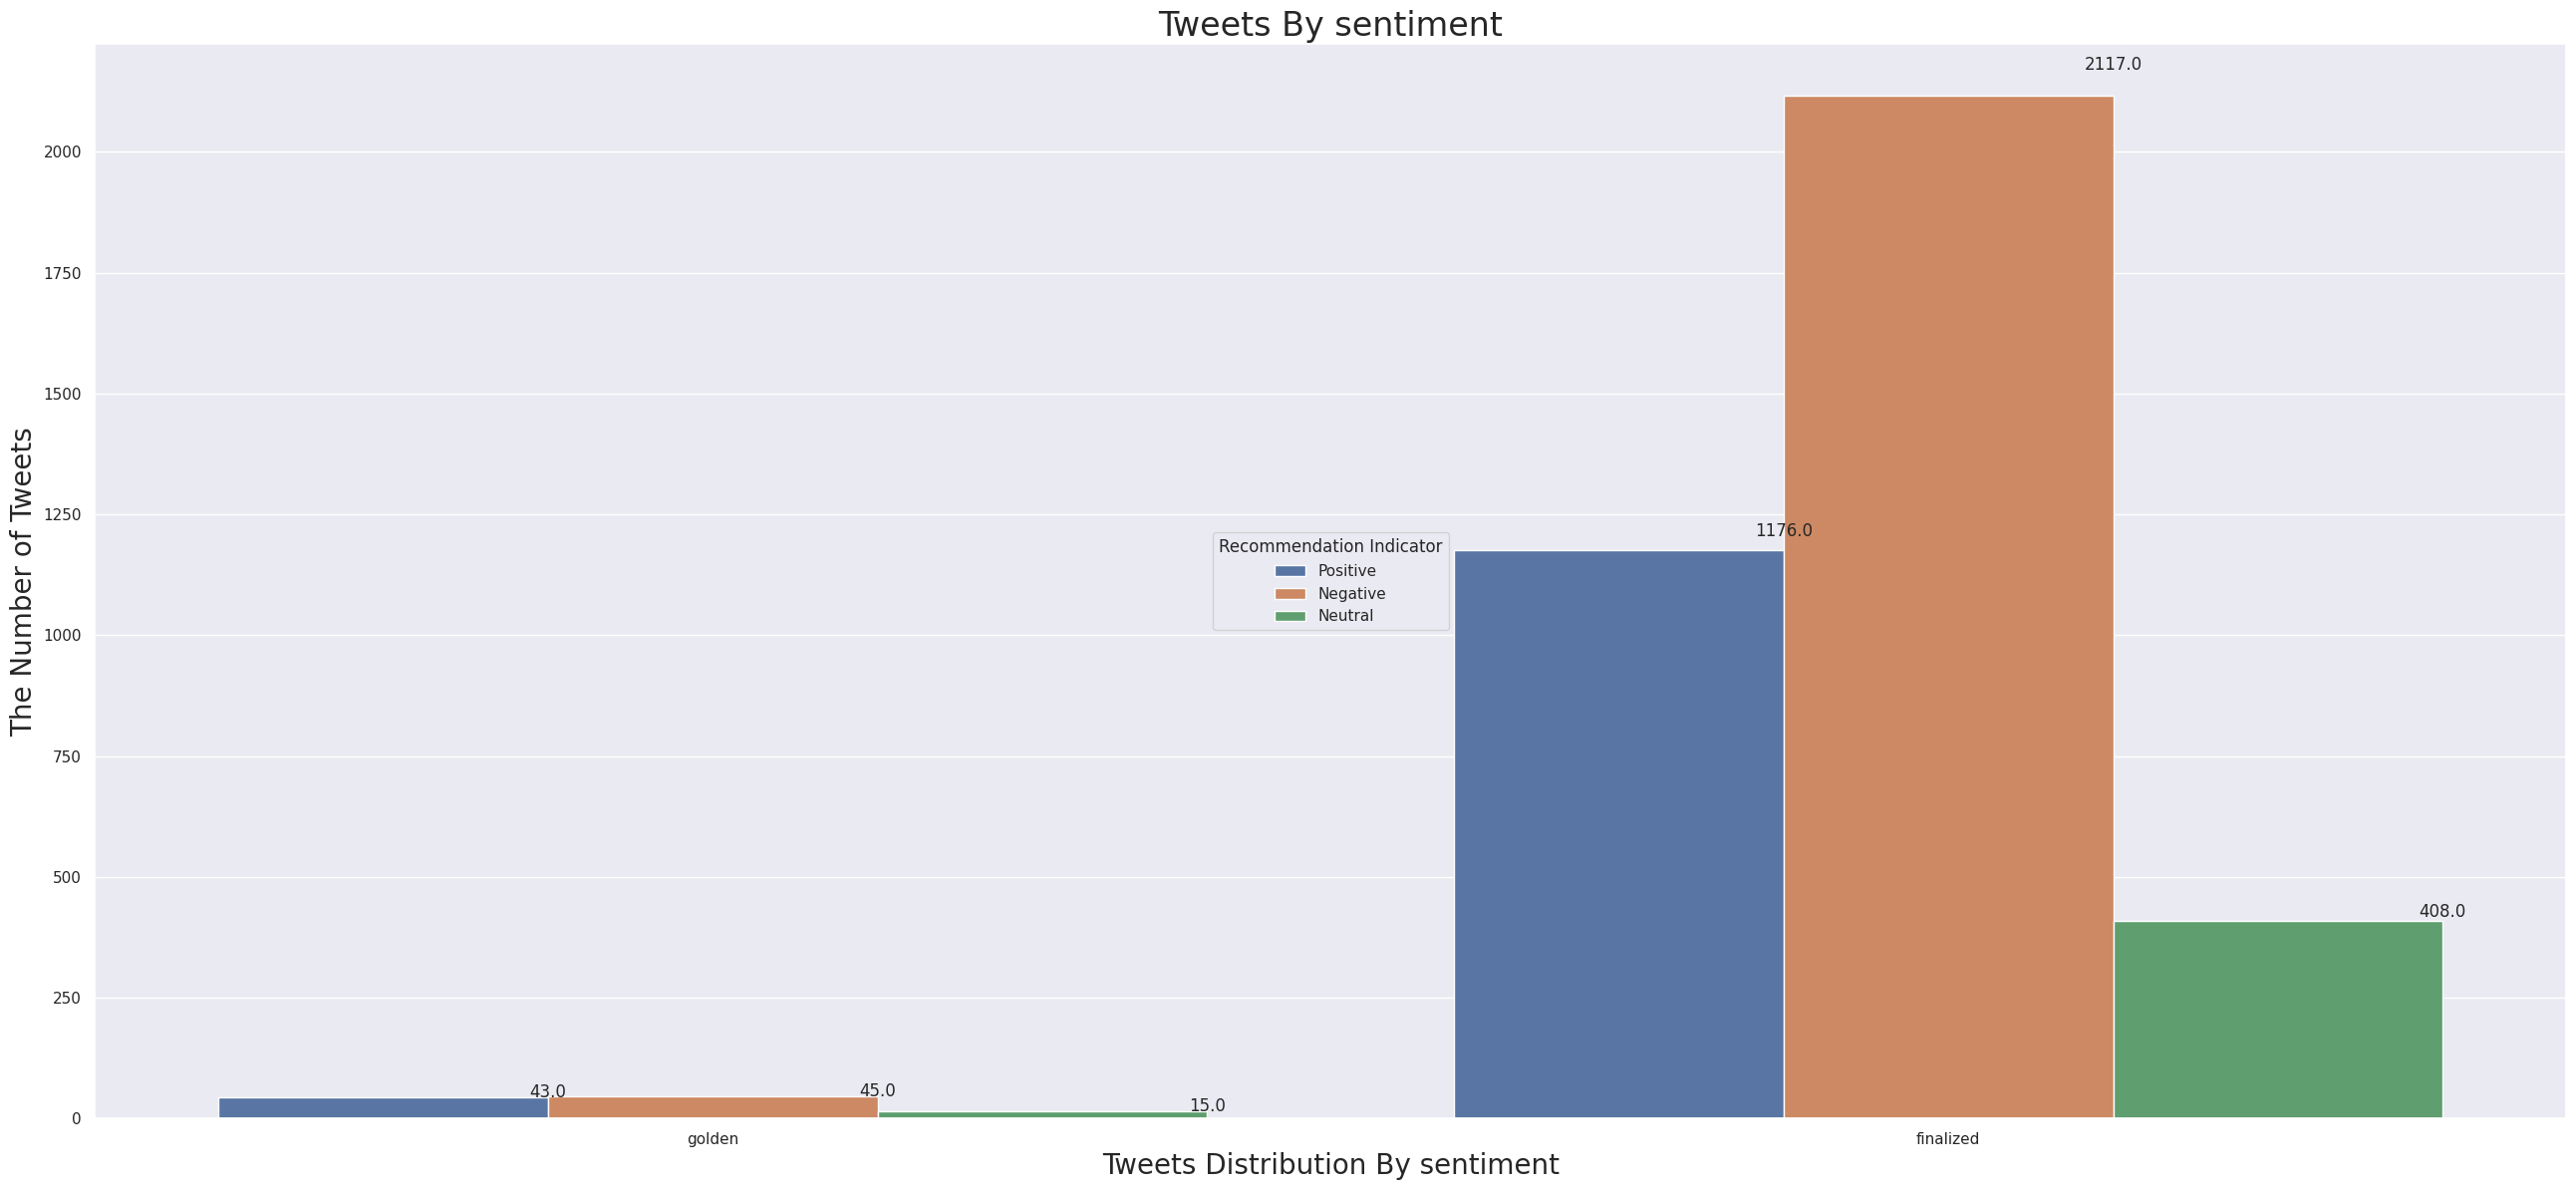

In [23]:
# Another set of bar charts looking at the distribution of sentiment by "_unit_state".
# "Golden" tweets have equal distribution of negative & positive tweets while
# "Finalized" had double the amount of negative tweets vs. postive

plt.figure(figsize=(32,14))
total = float(len(data))
ax = sns.countplot(x="_unit_state", hue = "sentiment", data=data)

plt.title('Tweets By sentiment', fontsize=24)
plt.xlabel("Tweets Distribution By sentiment", fontsize=20)
plt.ylabel("The Number of Tweets", fontsize=20)
plt.legend(title='Recommendation Indicator', loc='center', labels=['Positive', 'Negative', 'Neutral'])

for p in ax.patches:
   # percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()* 1.025
    ax.annotate(p.get_height(), (x, y),ha='center')

plt.show()

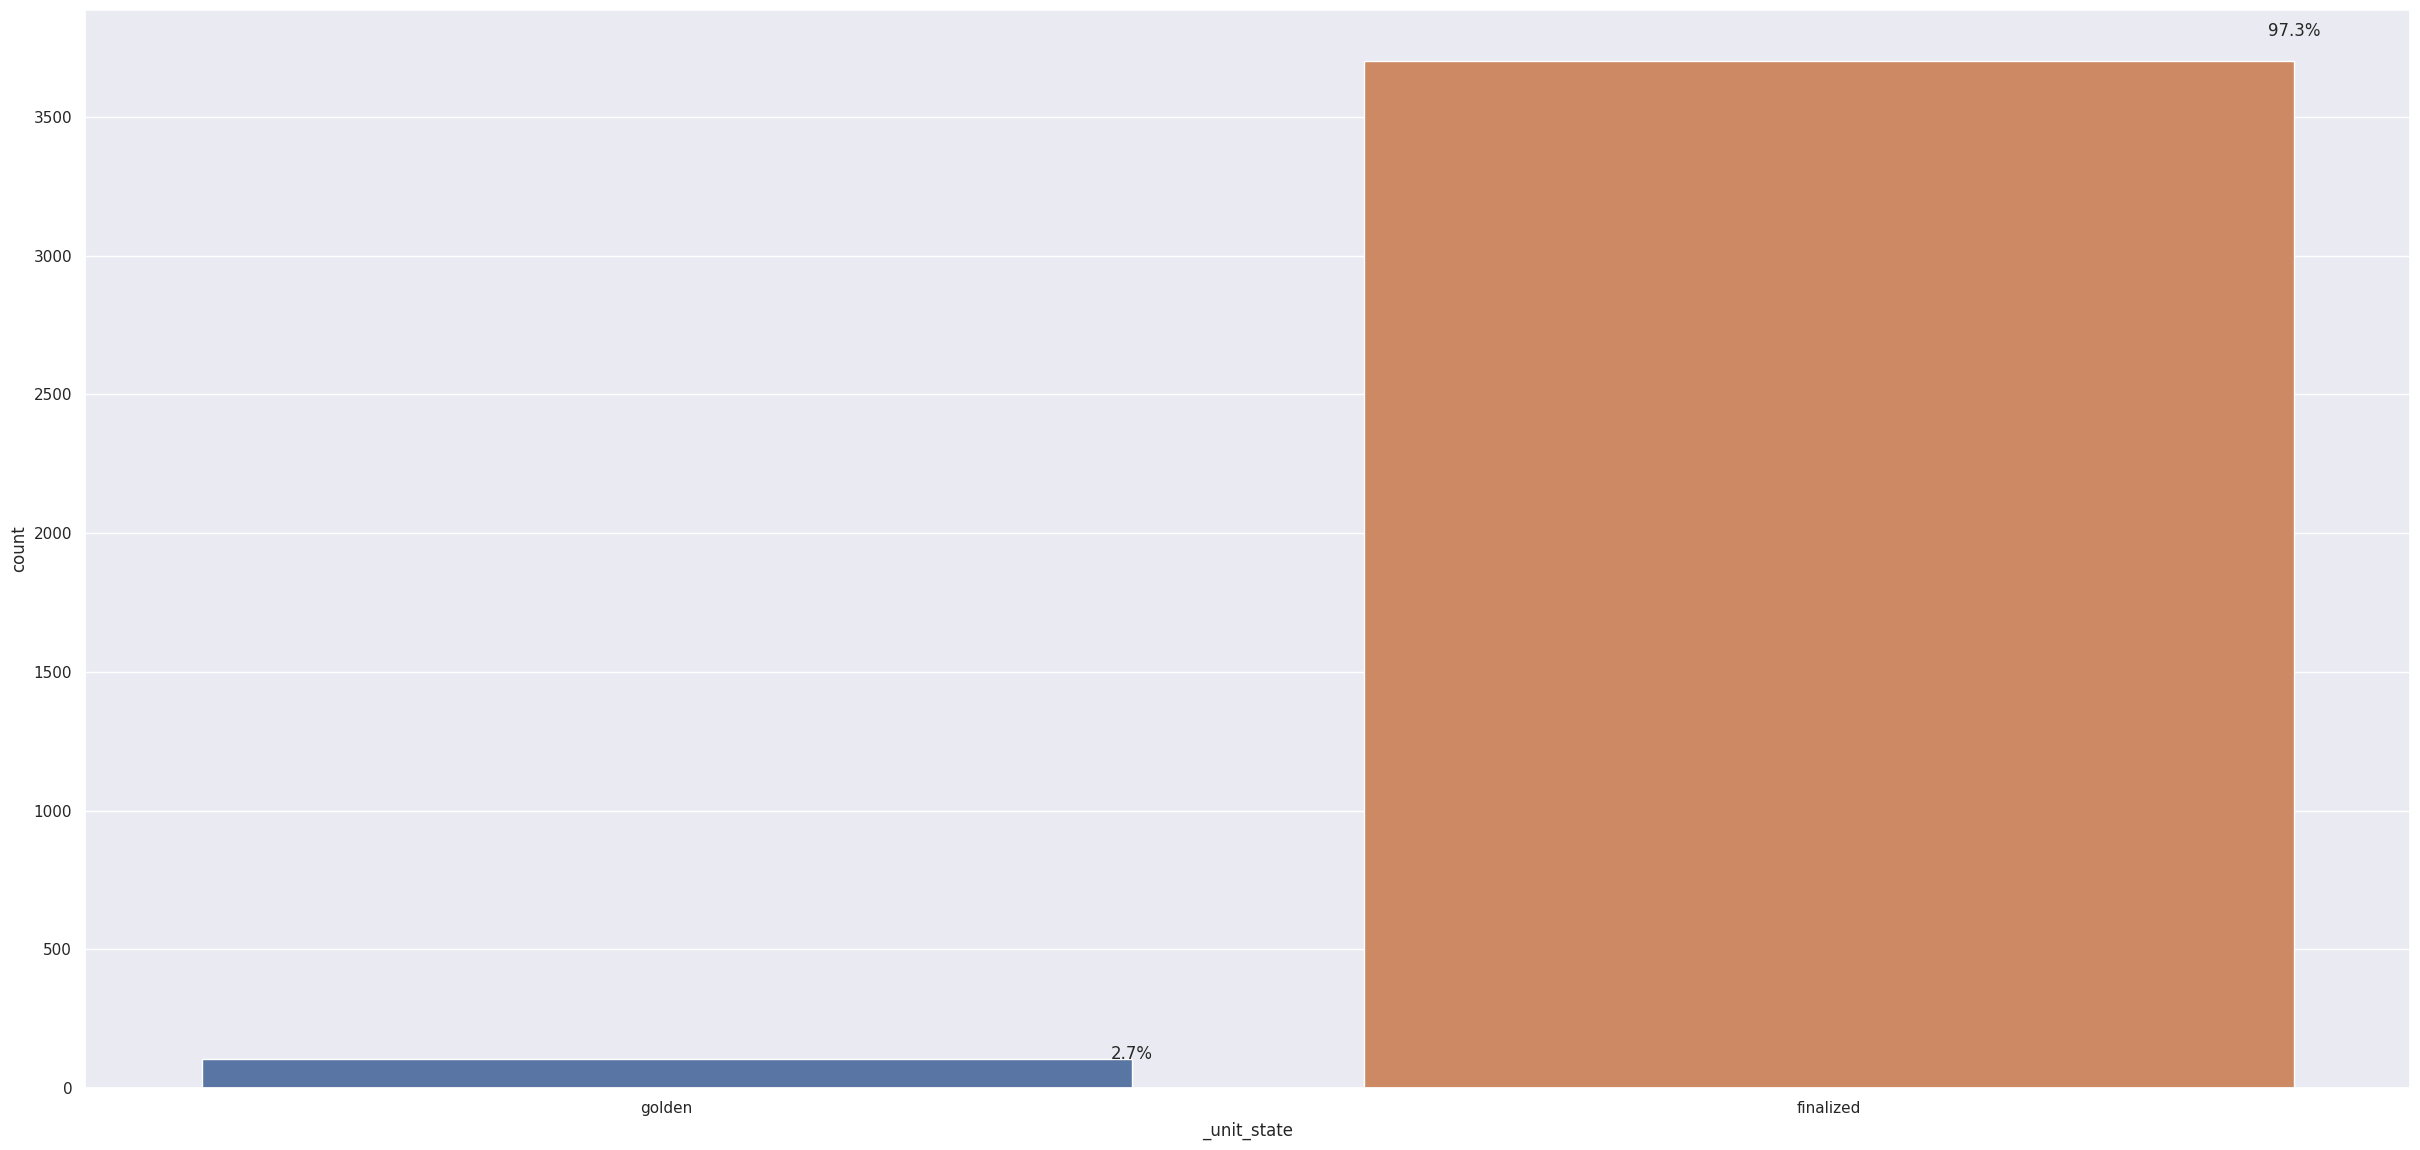

In [24]:
# Another bar chart just looking at the total of tweets by _unit_state
plt.figure(figsize=(30,14))
total = float(len(data))
ax = sns.countplot(x="_unit_state", data=data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()* 1.025
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

### Feature Extraction

In [25]:
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text,sentiment_level
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...,Negative
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,Negative
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...,Negative
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...,Negative
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL,Negative


In [26]:
# For NLP just kept necessary columns such as "text" and "sentiment-level" columns. Deleted the rest
data.drop(["_unit_id", "_golden", "_unit_state", "_trusted_judgments", "_last_judgment_at", "sentiment", "sentiment:confidence", "date", "id", "query", "sentiment_gold"], axis = 1, inplace = True)

In [27]:
data.head()

,text,sentiment_level
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,Negative
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,Negative
2,My cat only chews @apple cords. Such an #Apple...,Negative
3,I agree with @jimcramer that the #IndividualIn...,Negative
4,Nobody expects the Spanish Inquisition #AAPL,Negative


In [28]:
# Check if the DataFrame has an index
has_index = data.index.any()

# Display the result
print("Does the DataFrame have an index?", has_index)

Does the DataFrame have an index? True


In [29]:
# Instantiating an object of WordNetLemmatizer class
lemmatizer = WordNetLemmatizer()

In [30]:
# function to get the simpler virsion of pos tag  to use  in lemmitazation
def get_simple_pos(tag): # Create a function get_simple_pos, passing one argument called tag
    if tag.startswith('N') or tag.startswith('J'): # if tag starts with N or J, return wordnet.NOUN
        return wordnet.NOUN #
    elif tag.startswith('V'): # if tag starts with V, return wordnet.VERB
        return wordnet.VERB
    elif tag.startswith('R'): # if tag starts with R, return wordnet.ADV
        return wordnet.ADV
    else:
        return wordnet.NOUN # Otherwise, return Noun

In [31]:
# Modifying the index with lambda so that the row starts with 1, rather than 0
data.index = data.index.map(lambda x: x + 1)

In [32]:
# Creating 'clean_texts' function
def clean_texts(tweet): #Define clean_texts, passing one argument, tweet.
    # Remove retweets (e.g., RT @username:)
    raw_tweet = re.sub(r'\bRT\b\s*@\w+:\s*', '', tweet)

    # Remove mentions (e.g., @username)
    raw_tweet = re.sub(r'@\w+', '', raw_tweet)

    # Remove hashtags and the following word
    raw_tweet = re.sub(r'#\w+\s*', '', raw_tweet)

    # Remove links (e.g., http://example.com)
    raw_tweet = re.sub(r'http\S+', '', raw_tweet)

    # Remove non-alphabetic characters (except spaces)
    raw_tweet = re.sub("[^a-zA-Z ]", " ", raw_tweet)

    # Remove numbers
    raw_tweet = re.sub("\d+(\.\d+)?", " ", raw_tweet)

    stop_words = set(stopwords.words("english")) # Setting English stop words
    words_tokens = word_tokenize(raw_tweet) # Tokenizes cleaned tweets into words
    clean_words = []

    for word, tag in pos_tag(words_tokens): # Create For Loop to iterate through each word in words_token list
        if word.lower() not in stop_words: # condition: If the current lower-case word are not in stop_words list
            pos = get_simple_pos(tag)  # get_simple_pos function to remove stop words
            # & lemmatizes remaining words
            clean_word = lemmatizer.lemmatize(word.lower(), pos=pos)
            # Lemmatizes lowercase version of current word, using the part-of-speech info. above (get_simple_POS)
            clean_words.append(clean_word) # append cleaned words in clean_word to the clean_words list

    return " ".join(clean_words) # return the string after joining the cleaned & lemmatized words with space

In [33]:
# store the cleaned text inside clean_text_corpus array
clean_text_corpus = []

for index, tweet in enumerate(data["text"]):
    # Starting for loop, to interate & keep track of the index
    # check if the string is empty before calling clean_texts
    if tweet:
        clean_text_corpus.append(clean_texts(tweet))
    else:
        # If the tweet is empty, append an empty string
        clean_text_corpus.append("")

# Now clean_text_corpus contains your cleaned texts

In [34]:
data["text"] = data["text"].apply(clean_texts) # apply clean_tweets function on each element of each row in text
data["text"].head()

1                     best steve job email ever
2        aapl stock mini flash crash today aapl
3                                 cat chew cord
4    agree trade extend today pullback good see
5             nobody expect spanish inquisition
Name: text, dtype: object

In [35]:
data.head()

,text,sentiment_level
1,best steve job email ever,Negative
2,aapl stock mini flash crash today aapl,Negative
3,cat chew cord,Negative
4,agree trade extend today pullback good see,Negative
5,nobody expect spanish inquisition,Negative


In [36]:
print("review 5 cleaned {",data["text"][5],"}") # Print sixth row in text as a string

review 5 cleaned { nobody expect spanish inquisition }


In [37]:
words_values = pd.Series(" ".join(data["text"]).split()).value_counts() # Split into string of words in text & count
print(words_values)
rare_words = words_values[words_values <= 3] #This line chooses words that appear three times or fewer
print(rare_words)
print(rare_words.value_counts()) #Prints the words & count

apple        797
need         431
one          388
computer     354
battery      353
            ... 
sir            1
faq            1
chocolate      1
err            1
unhelpful      1
Length: 4060, dtype: int64
interface    3
content      3
private      3
plane        3
recap        3
            ..
sir          1
faq          1
chocolate    1
err          1
unhelpful    1
Length: 2913, dtype: int64
1    1973
2     644
3     296
dtype: int64


In [38]:
# Apply lambda function to each element in the text column by splitting each word if the word is not rare_words. index ensures order is preseved.
data["text"] = data["text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
data["text"].head()

1                 best steve job email ever
2    aapl stock mini flash crash today aapl
3                                  cat cord
4                agree trade today good see
5                                    expect
Name: text, dtype: object

In [39]:
# Create function to display wordcload
def create_WordCloud(data, back_ground_color = "black", title = None):
  wordcloud = WordCloud(background_color=back_ground_color, max_words=300, max_font_size=30 , scale=3,random_state=1).generate(str(data))
  mpl.rcParams['figure.figsize']=(15,15)
  mpl.rcParams['font.size']=20
  #plt.style.use('fast')
  fig = plt.figure(1)
  if title:
    plt.title(title, fontsize= 30)

  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

In [40]:
# seprate the pos and neg words
#Negative_words = " ".join(data[data["text"]  =="0"]in categories).split()

# seprate the pos and neg words
Negative_words =[]
Positive_words=[]


#clean_reviews(data["verified_reviews"][index]
for index, num in enumerate(categories):
    if num == 1:
        Positive_words.append(data["text"].iloc[index])
    else:
        Negative_words.append(data["text"].iloc[index])

In [41]:
Negative_words[:20]

['best steve job email ever',
 'aapl stock mini flash crash today aapl',
 'cat cord',
 'agree trade today good see',
 'expect',
 'stock buy december gain apple',
 'apple inc flash crash need know',
 'show make world biggest tech company',
 'wtf battery one second ago wtf',
 'apple watch top search engine list best wearable tech',
 'best design world accord',
 'contact sync yosemite io seriously screw use much past',
 'thanks non dumb twitter stock drop point one minute thanks',
 'buy iphone iphone use verizon network',
 'thanks store appointment run almost minute late',
 'stock mini flash crash today money morning nothing analyst suggest would make',
 'staff issue macbook ipad mini',
 'need ip portfolio defend big company look court battle',
 'love center damn calendar app fix back center',
 'get storage almost full notification literally every minute']

In [42]:
Positive_words[:20]

['top damn right',
 'cnbctv margin well expect',
 'store pretty good logo match wait install',
 'latest apple product',
 'thanks think upgrade',
 'photo love io',
 'update gb guy like take money dammit look good',
 'io user account online sale x user dominate',
 'please new phone christmas',
 'well play',
 'thank',
 'thank',
 'love product power cord junk seriously need fix',
 'rt apple share billion',
 'even apple watch raise aapl price target',
 'love amp earn sale',
 'maybe good product never better macbook air fact',
 'great news hope wifi get sort though',
 'photo',
 'service today store thanks amp sort battery problem amp']

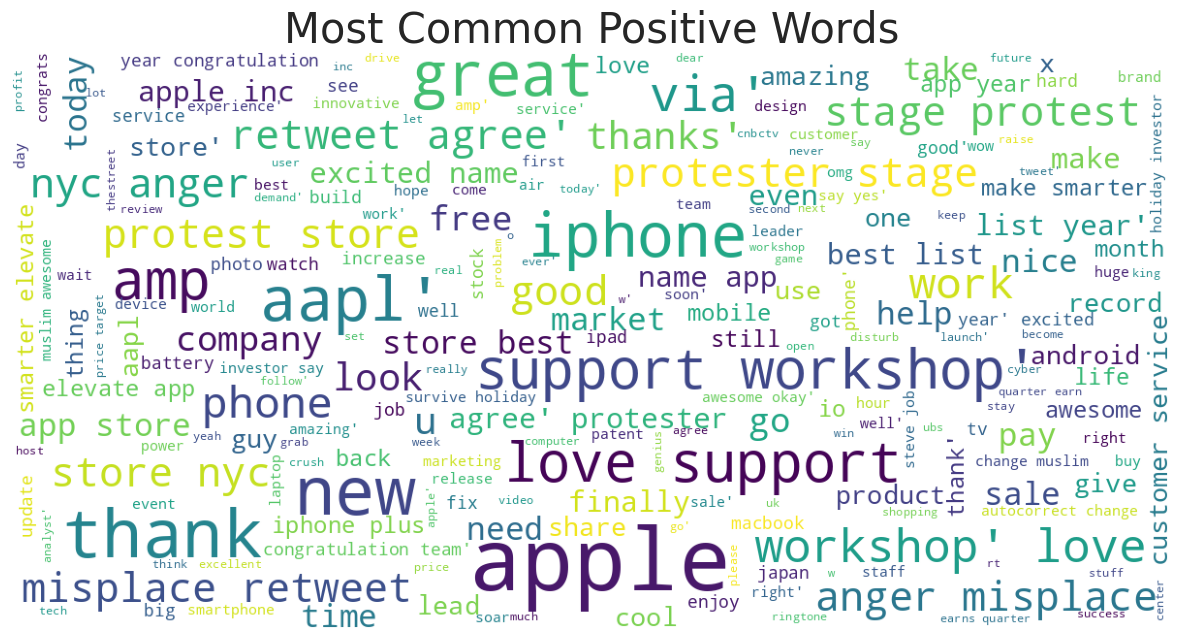

In [43]:
# wordcload for positive words
create_WordCloud(Positive_words, back_ground_color = "white", title = "Most Common Positive Words")

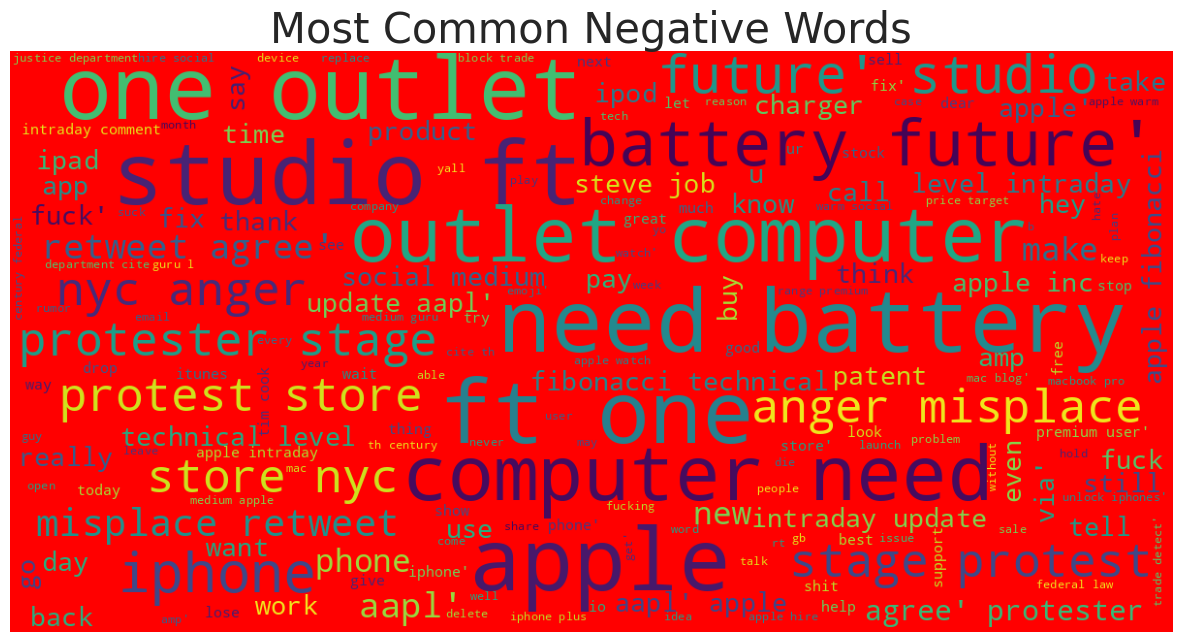

In [44]:
# wordcload for negative words
create_WordCloud(Negative_words, back_ground_color="red",title="Most Common Negative Words")

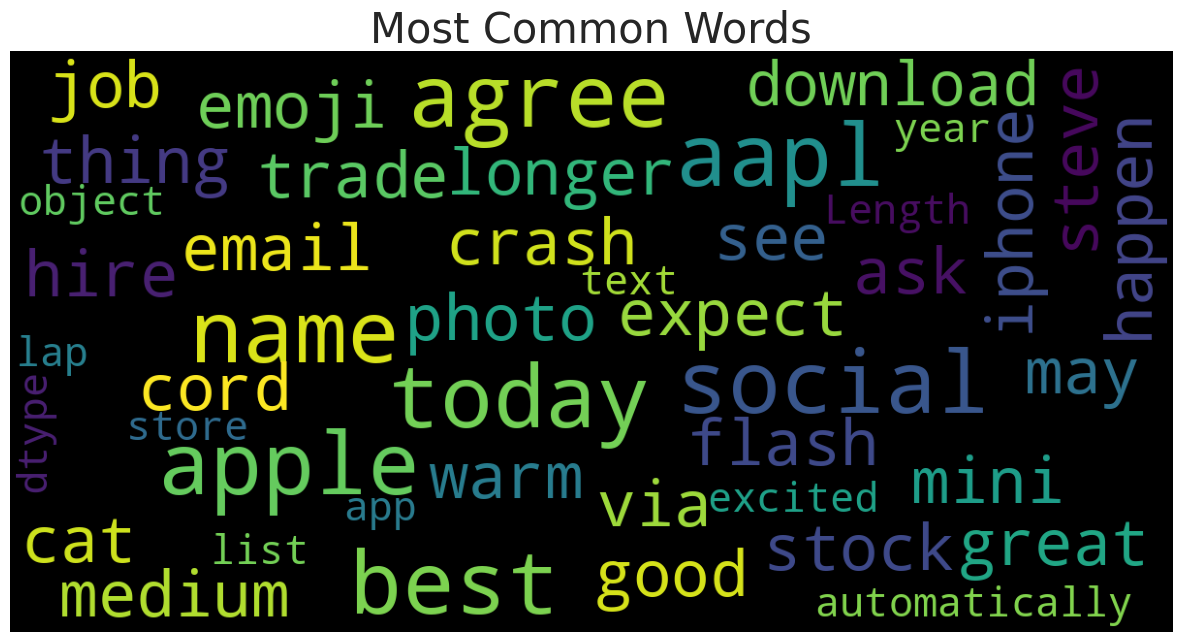

In [45]:
# wordcload for all words
create_WordCloud(data["text"], title = "Most Common Words")

In [46]:
# Top 15 positive tweeets
freq_pos = nltk.FreqDist(Positive_words)
freq_pos.most_common(15)

[('love support workshop', 20),
 ('protester stage protest store nyc anger misplace retweet agree', 12),
 ('excited name app store best list year', 8),
 ('make smarter elevate app year congratulation team', 6),
 ('', 5),
 ('thank', 4),
 ('autocorrect change muslim awesome okay', 4),
 ('survive holiday investor say yes', 3),
 ('biggest difference yep stick mac', 3),
 ('earns quarter earn lifetime', 3),
 ('enjoy launch event amazing leader room', 2),
 ('new excellent update phone', 2),
 ('love', 2),
 ('goodbye graphic problem thank great customer service', 2),
 ('got new case', 2)]

In [47]:
# Top 15 negative reviews
freq_neg=nltk.FreqDist(Negative_words)
freq_neg.most_common(10)

[('studio ft one outlet computer need battery future', 309),
 ('protester stage protest store nyc anger misplace retweet agree', 139),
 ('apple fibonacci technical level intraday update aapl', 46),
 ('', 43),
 ('justice department cite th century federal law get unlock iphones', 19),
 ('block trade detect', 17),
 ('apple intraday comment updated range premium user', 16),
 ('apple warm social medium apple hire social medium guru l finally tweet',
  15),
 ('apple important stock earth', 14),
 ('fuck', 13)]

# Deep Learning

## Test, Train Split & Vectorization

In [48]:
# train-test-data set split
x_train, x_test, y_train, y_test = train_test_split(data["text"], categories, stratify = categories, test_size = 0.20, random_state = 42)

In [49]:
# Vectorization
# here we create new CountVectorizer, which will help us understand and count the words.
# Turn text into numerical format. In this case, coverting a collection of text docuyment into a matrix of token counts
# and it has different ways to use it, but we will only use it with  1-2 grams or single words or two-word sequences
count_vec = CountVectorizer(ngram_range = (1,2))

In [50]:
# vectorizer to read the train text
x_train_features = count_vec.fit_transform(x_train) #covert training data into a matrix of token counts
x_train_features = x_train_features.toarray() # to get the frequincy of the words; converts into array

In [51]:
x_test_features = count_vec.transform(x_test) #covert test data into a matrix of token counts

In [52]:
# TF-IDF Vectorization - "Term-Frequency-Inverse Document Frequency Vectorization"
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2)) #Creates instance of TfidVectorizer class with parameter - 1 word or 2 word seq.
X_train_Tfid = tfidf_vectorizer.fit_transform(x_train) #append to training data
X_test_Tfid = tfidf_vectorizer.transform(x_test) #append to test

In [53]:
X_train_Tfid.toarray() #convert tratin to array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Deep Learning -- Neural Network

In [54]:
# find the length of the largest sentence in training data
max_len = max(x_train, key = len)
print(f'Max number of words in a text in training data: {len(max_len)}')

Max number of words in a text in training data: 88


In [71]:
# Convert text to padded sequences
max_words = 88
tokenizer = Tokenizer(num_words = max_words) #Create instance of Tokenizer class from Keras with maximum word parameter

In [72]:
# create the vocabulary by fitting on X_train text
tokenizer.fit_on_texts(x_train) #Fit tokenzier on train data (before converting text to sequences of tokens)

In [73]:
# get the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(x_train)
xtest_seq = tokenizer.texts_to_sequences(x_test)

In [74]:
# padding the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=len(max_len)) #Pad to maximum of tokenenized sentecnes
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=len(max_len))
word_index = tokenizer.word_index #Word_index is dictionary where keys are words; their values now corresponding unique integer ids.

In [75]:
# get a random example
print('train review num 10:', x_train[9])
print('before padding:', xtrain_seq[9])
print('after padding:', xtrain_pad[9])

train review num 10: apple inc flash crash need know
before padding: [8, 9, 3, 10, 4, 2, 5, 7]
after padding: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  8  9  3 10  4  2  5  7]


In [76]:
# data shape after padding
print(xtrain_pad.shape)
print(xtest_pad.shape)
print(y_train.shape)
print(y_test.shape)

(3043, 88)
(761, 88)
(3043, 1)
(761, 1)


### Creating the network

In [77]:
def create_model(): # defining function for Keras neural network model (Long Short Term Memory)
    model = tf.keras.models.Sequential([tf.keras.layers.Embedding(max_words, 100, input_length=max_words),
                                        tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, padding ='same', activation='relu'),
                                        tf.keras.layers.MaxPooling1D(pool_size = 2),
                                        tf.keras.layers.LSTM(256),
                                        tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(3e-4), metrics=['accuracy'])
    return model

In [78]:
model = create_model() # Show snapshop of model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 88, 100)           8800      
                                                                 
 conv1d_1 (Conv1D)           (None, 88, 32)            6432      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 44, 32)            0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 256)               295936    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 311425 (1.19 MB)
Trainable params: 311425 (1.19 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

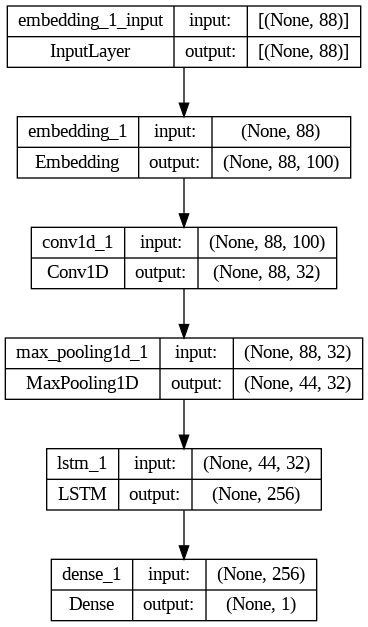

In [79]:
# print the block diagram of our model
plot_model(model, show_shapes = True, show_layer_names = True)

### Training the Network

In [80]:
# Setting EarlyStopping callback for Keras during training. Callback stops training model when accuracy stops improving
# create model checkpoint and callbacks to save the model weights when validation accuracy is maximum
callback=tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 2, mode = 'auto', baseline = None, restore_best_weights = True)

In [81]:
# Making sure GPU is available
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

Found GPU at: /device:GPU:0


In [83]:
# fit the model
with tf.device('/device:GPU:0'):
  history = model.fit(
        xtrain_pad, # Training data with padded sequences
        y_train, # corrensponding Training labels
        validation_data = (xtest_pad, y_test),  # specifies validation data and labels
        class_weight = {0:87, 1:13},  # Class weights for handling imbalance
        epochs = 10,  # Number of epochs (iterations over entire training dataset)
        batch_size = 32 # Batch size for each iteratiion (mini-batch)
  )

Epoch 1/10
96/96 [==============================] - 1s 13ms/step - loss: 5.9960 - accuracy: 0.8948 - val_loss: 0.3985 - val_accuracy: 0.8962
Epoch 2/10
96/96 [==============================] - 1s 8ms/step - loss: 5.8945 - accuracy: 0.8948 - val_loss: 0.3860 - val_accuracy: 0.8975
Epoch 3/10
96/96 [==============================] - 1s 10ms/step - loss: 5.8838 - accuracy: 0.8952 - val_loss: 0.3769 - val_accuracy: 0.8975
Epoch 4/10
96/96 [==============================] - 1s 8ms/step - loss: 5.8418 - accuracy: 0.8962 - val_loss: 0.4007 - val_accuracy: 0.8962
Epoch 5/10
96/96 [==============================] - 1s 10ms/step - loss: 5.8524 - accuracy: 0.8958 - val_loss: 0.3819 - val_accuracy: 0.8975
Epoch 6/10
96/96 [==============================] - 1s 10ms/step - loss: 5.7480 - accuracy: 0.8962 - val_loss: 0.3736 - val_accuracy: 0.8975
Epoch 7/10
96/96 [==============================] - 1s 8ms/step - loss: 5.7894 - accuracy: 0.8965 - val_loss: 0.3529 - val_accuracy: 0.8975
Epoch 8/10
96/96

In [84]:
# predict probabilities for test set
y_probs = model.predict(xtest_pad, verbose = 0)

In [85]:
# predict classes for test set
y_classes = (model.predict(xtest_pad) > 0.5).astype("int32")
y_train_pred=(model.predict(xtrain_pad) >= 0.5).astype("int32")

96/96 [==============================] - 0s 3ms/step


In [86]:
# Model evaluation
train_nn_results = model.evaluate(xtrain_pad, y_train, verbose=0)
test_nn_results = model.evaluate(xtest_pad, y_test, verbose=0)
print(f'Train accuracy: {train_nn_results[1]*100:0.2f}')
print(f'Test accuracy: {test_nn_results[1]*100:0.2f}')

Train accuracy: 90.08
Test accuracy: 89.88


In [87]:
model.save('final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [88]:
review_1 = "I HATE HOW IOS 8 CAPITALIZES RANDOM WORDS LIKE I DONT WANNA GIVE EMPHASIS TO SOME STUPID WORD IN THA SENTENCE GET UR SELF TOGETHER @Apple"
review_2 = "Why is my phone on 26 if I charged it all night hmmmmm? @apple @stevejobs @god"
review_3 = "What I find alarming about @Apple power cords is how quickly they fray.  I don't always notice when I don't travel with them. #AppleCordFire"
review_4 = "#Apple: Facing A Challenge From Google's Android - Apple Inc. #AAPL | Seeking Alpha http://t.co/Fd4E1Pv5G4"
review_5 = "@Apple my wifi is on &amp; working on everything else but my ipad. i'm so pissed. TWO DAYS it's been like this! GET IT TOGETHER #Apple"
review_6 = "Dear @apple , please find a solution to this, it happens with all of your cords: http://t.co/MsnP6PI2O9"

reviews = [review_1, review_2, review_3, review_4, review_5, review_6]

In [89]:
results = {}
preds = []
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequences
    model_= load_model("final_model.h5")
    sequence = pad_sequences(sequence, maxlen = max_words)
    # get the prediction
    prediction = model_.predict(sequence)[0]
    if (np.round(prediction, 2) >= 0.5):
        pred = "Positive"
    else:
        pred = "Negative"
    return pred

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [91]:
for ind, review in enumerate(reviews):
    prediction = get_predictions(review)
    preds+=[prediction]
    results["CNN_LSTM_Model"] = preds

1/1 [==============================] - 1s 552ms/step


1/1 [==============================] - 1s 555ms/step


1/1 [==============================] - 1s 535ms/step


In [92]:
# df_reviews = pd.DataFrame(reviews, index=["Review 1", "Review 2"])
df_reviews = pd.DataFrame(reviews, index=["Review 1", "Review 2", "Review 3", "Review 4", "Review 5", "review 6"])

display(HTML(df_reviews.to_html()))

# df = pd.DataFrame.from_dict(results, orient ='index', columns = ["Review 1", "Review 2"])
df = pd.DataFrame.from_dict(results, orient ='index', columns = ["Review 1", "Review 2", "Review 3", "Review 4", "Review 5", "review 6"])

df.style.set_table_styles([{"selector": ".row2,.row3,.row6", "props": [("border", "2px solid black"), ("color", "black"), ("background-color", "lightgreen")]},
                           {"selector": "thead", "props":"background-color:aqua; color:black; border:3px solid black;"}])

,0
Review 1,I HATE HOW IOS 8 CAPITALIZES RANDOM WORDS LIKE I DONT WANNA GIVE EMPHASIS TO SOME STUPID WORD IN THA SENTENCE GET UR SELF TOGETHER @Apple
Review 2,Why is my phone on 26 if I charged it all night hmmmmm? @apple @stevejobs @god
Review 3,What I find alarming about @Apple power cords is how quickly they fray. I don't always notice when I don't travel with them. #AppleCordFire
Review 4,#Apple: Facing A Challenge From Google's Android - Apple Inc. #AAPL | Seeking Alpha http://t.co/Fd4E1Pv5G4
Review 5,@Apple my wifi is on &amp; working on everything else but my ipad. i'm so pissed. TWO DAYS it's been like this! GET IT TOGETHER #Apple
review 6,"Dear @apple , please find a solution to this, it happens with all of your cords: http://t.co/MsnP6PI2O9"


,Review 1,Review 2,Review 3,Review 4,Review 5,review 6
CNN_LSTM_Model,Negative,Negative,Negative,Negative,Negative,Negative
